# Data

This notebook gives an overview of the dataset used in the joint Crab paper.   
The data are organized in the [folder data](data) according to their instrument of origin.

In [1]:
!ls -1 data

fact
fermi
hess
magic
other
README.md
veritas


## Events and IRFs
As explained in Section of 2 of the paper, the gamma-ray data stored in FITS format, consits of 
* Event Lists (containing events classified as photons)
* Instrument Response Functions (IRFs)   

The data, dubbed data level 3 (DL3) in jargon, are compliant with the specifications in the [Data formats for gamma-ray astronomy](https://gamma-astro-data-formats.readthedocs.io/en) forum.   
The novelty of this paper is the implementation of the open data format for all the IACT datasets, we will use the `DataStore` class of `gammapy` to examine one of them.

In [2]:
%matplotlib inline
from gammapy.data import DataStore

In [3]:
data_store = DataStore.from_dir("data/veritas")
data_store.info()

Data store:
HDU index table:
BASE_DIR: data/veritas
Rows: 8
OBS_ID: 54809 -- 57993
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti']

Observation table:
Observatory name: 'N/A'
Number of observations: 2


Given that IACT performances are dependent on the observing conditions, their datasets are released in chunks of 20-30 mins of stable data acquisition (DAQ), called observations (or runs). As we can see from the `info()` VERITAS released 2 datsets from this project with identification number (54809 and 57993). Each dataset comes with an **observation table** providing technical informations about the observation: pointing (equatorial (`RA_PNT`, `DEC_PNT`) and local (`ALT_PNT`, `AZ_PNT`) coordinates), number of telescopes used (`N_TELS`), live-time of the observation (`LIVETIME`) and dead-time fraction due to the DAQ (`DEADC`), etc.

In [4]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
54809,83.097374,22.017342,9.851054,80.14895,189.35764,1203.0,1094.6516,0.9099348,189575870.0,189577070.0,4,"T1,T2,T3,T4"
57993,83.642456,22.515266,9.337985,80.66202,188.49199,1201.0,1086.8257,0.904934,210944640.0,210945860.0,4,"T1,T2,T3,T4"


Beside the **observation table**, a **data unit table** lists the components of the DL3 files. Each of them has an `EVENTS` unit and a separate unit for each IRF component: `EFFECTIVE AREA`, `ENERGY DISPERSION`. (Note the `GTI`, good time intervals, are not currently used in gammapy). 

In [5]:
data_store.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,bytes6,bytes10,bytes40,bytes54,bytes20
54809,gti,gti,,54809_DL3.fits,GTI
54809,events,events,,54809_DL3.fits,EVENTS
54809,aeff,aeff_2d,,54809_DL3.fits,EFFECTIVE AREA
54809,edisp,edisp_2d,,54809_DL3.fits,ENERGY DISPERSION
57993,gti,gti,,57993_DL3.fits,GTI
57993,events,events,,57993_DL3.fits,EVENTS
57993,aeff,aeff_2d,,57993_DL3.fits,EFFECTIVE AREA
57993,edisp,edisp_2d,,57993_DL3.fits,ENERGY DISPERSION


## Maps
An immediate way to visualize the events is to create a simple count map. We use the `WcsNDMap` map class of `gammapy` and `astropy.coordinates`

In [6]:
from gammapy.maps import WcsNDMap
from astropy.coordinates import SkyCoord

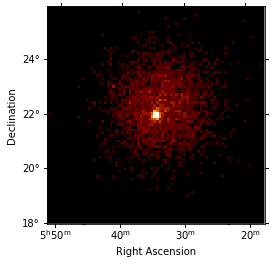

In [7]:
# Crab Nebula position, center of the skymap
source_pos = SkyCoord("83d37m59.0988s", "22d00m52.2s")
counts_map = WcsNDMap.create(skydir=source_pos, proj="TAN", width=8, binsz=0.1)

# fill and plot the skymap
for obs_id in data_store.obs_table["OBS_ID"]:
    table = data_store.obs(obs_id).events.table
    counts_map.fill_by_coord((table["RA"], table["DEC"]))

fig, ax, im = counts_map.plot(stretch="sqrt")

## Spectra
As described in Section 3.1, the results of the spectrum extraction constitute the input for the likelihood minimization. Events are separated in ON and OFF counts, through the signal and background control regions described in Section 3.1. For the VERITAS dataset we use a signal ON region of 0.1 deg, centered on the Crab position. `gammapy`'s `ReflectedRegionsBackgroundEstimate` will automatically maximimze the number of OFF regions mirroring the ON position w.r.t. the camera center. Let's display the process for the runs of VERITAS.

In [8]:
import astropy.units as u
from regions import CircleSkyRegion
from gammapy.background import ReflectedRegionsBackgroundEstimator

In [9]:
observations = data_store.get_observations([54809, 57993])
# define the ON region
on_region = CircleSkyRegion(center=source_pos, radius=0.1 * u.deg)
# run the background estimate
bkg_estimate = ReflectedRegionsBackgroundEstimator(
    observations=observations, 
    on_region=on_region,
)
bkg_estimate.run()

/home/cosimo/software/miniconda3/lib/python3.7/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


(<Figure size 432x288 with 1 Axes>,
 None)

/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/cosimo/software/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/cosimo/software/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/cosimo/software/mi

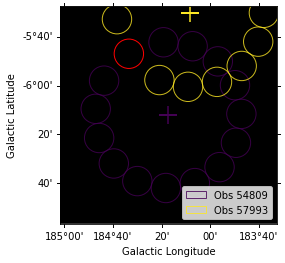

In [10]:
bkg_estimate.plot(add_legend=True)

The ON region is marked in red for both runs, the maximized OFF regions are displayed in yellow and purple. The cross marks the camera center, i.e. the pointing position. (Note IACT observations do not have the source in the camera center ([Fomin 1994](http://adsabs.harvard.edu/abs/1994APh.....2..137F))).

Now the ON and OFF counts, binned in energy, constitute the data of our likelihood (cfr. Section 3.1). In order to compute predicted counts the IRFs are interpolated at nodes corresponding to the centers of the same energy bins of the counts and then folded with the assumed spectral model, see [Piron 2001](http://adsabs.harvard.edu/abs/2001A%26A...374..895P) for the mathematical details.      
The spectral data (ON and OFF counts and interpolated IRFs), are stored in the [ogip format](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html). They can constitute the input for any likelihood, therefore releasing this quantities as a spectral measurement, will allow future theoretical interpretaions with likelihood methods.    
The spectral data are handled by the `gammpy` class `SpectrumObservationList`. 

In [11]:
from gammapy.spectrum import SpectrumObservationList

In [12]:
spectrum_observations = SpectrumObservationList.read("results/spectra/veritas")
print(spectrum_observations)

SpectrumObservationList
Number of observations: 2


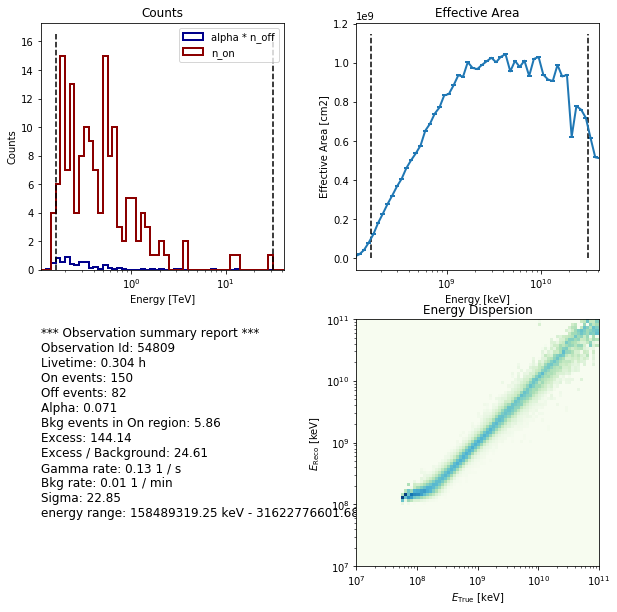

In [13]:
spectrum_observations[0].peek()

The `peek()` method offers a nice overview of the spectral data. In the top left corner we see the histogram of the ON and OFF counts, the latter scaled by the ratio of the ON to OFF total areas. The top right corner displays the effective area and the $E_{\rm min}$ and $E_{\rm max}$ energy range outside which the likelihood contribution has not to be calculated (cfr. Section 3.1). The bottom row shows on the left additional information on the observation and the energy dispersion on the right. 